# 데이콘 이상탐지 데이터 분석
---

In [1]:
!pip install --upgrade matplotlib

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\leonk\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


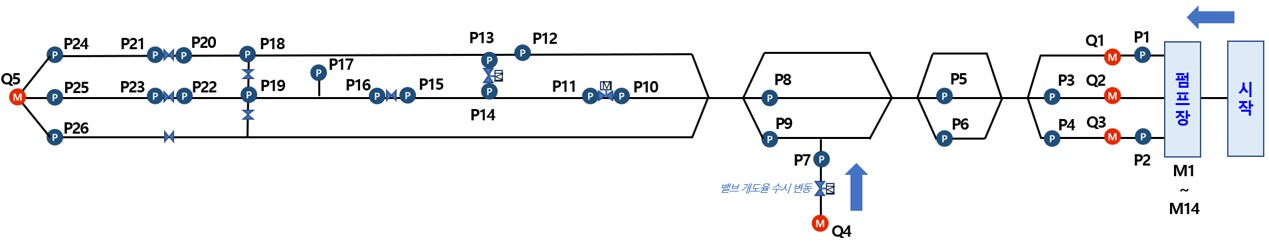

# M7펌프가 24/06/26 05:58 1에서 0으로 변함
# 압력계가 비정상이되면 14:20-부터 급격히 떨어지다가 정상화된 14:50부터 다시 올라감
- P가 anomaly 관측에 주요 변수로 보임(P8)
- 밸브 개도율 수시 변동과 p8 p9 사이 상관관계 가능
- Q4는 굉장히 중요한 변수다
- Q5가 완전 음에서 완전 양으로 바뀐다
- p7하고 q4가 상관관계 -1에 가까워 q4와 p7사이에 밸브는 개도율이 수시로 변동한다 
- p7이 압력이 높아졌을 때 밸브를 닫아서 q4의 유량이 감소했을 가능성이 있음
- 베르누이 원리에 의해서 정상상태에서는 유량과 압력이 음의 상관관계다
- 근데 anomaly상황에서 q5에서 양의 상관관계다
Anomaly 상황에서 유량과 압력이 양의 상관관계를 보이는 것은 시스템에 비정상적인 상태가 발생했음을 시사합니다. 이는 다음과 같은 상황을 나타낼 수 있습니다:
누수 발생: 파이프라인에 누수가 발생하면, 압력이 증가함에 따라 누수 지점을 통한 유량도 증가할 수 있습니다2. 이는 정상적인 흐름과는 다른 패턴을 보이게 됩니다.
막힘 현상: 파이프라인에 부분적인 막힘이 발생하면, 압력이 증가하면서 동시에 유량도 증가할 수 있습니다. 이는 막힘을 통과하기 위해 더 높은 압력이 필요하기 때문입니다2.
펌프 오작동: 시스템 내 펌프가 비정상적으로 작동하면, 압력과 유량이 동시에 증가하는 현상이 나타날 수 있습니다3.
밸브 오작동: 제어 밸브가 제대로 작동하지 않으면, 압력과 유량 사이의 정상적인 관계가 무너질 수 있습니다.
결론
이러한 관찰 결과는 시스템의 정상 상태와 비정상 상태를 구분하는 중요한 지표가 될 수 있습니다4. 유량과 압력 사이의 관계가 갑자기 변화하는 것은 시스템에 문제가 발생했음을 나타내는 신호일 수 있으며, 이를 통해 조기에 문제를 감지하고 대응할 수 있습니다. 따라서 이러한 패턴 변화를 모니터링하는 것은 수도 공급 시스템의 효율적인 관리와 유지보수에 매우 중요합니다5.

# 데이터 정보

In [3]:
df_A = pd.read_csv("TRAIN_A.csv")

print(df_A.columns)
print("칼럼 수 : ",len(df_A.columns))
print("차원 : ",df_A.shape)

Index(['timestamp', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'M1', 'M2', 'M3', 'M4', 'M5',
       'M6', 'M7', 'M8', 'M9', 'M10', 'M11', 'M12', 'M13', 'M14', 'P1', 'P2',
       'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 'P13',
       'P14', 'P15', 'P16', 'P17', 'P18', 'P19', 'P20', 'P21', 'P22', 'P23',
       'P24', 'P25', 'P26', 'anomaly', 'P1_flag', 'P2_flag', 'P3_flag',
       'P4_flag', 'P5_flag', 'P6_flag', 'P7_flag', 'P8_flag', 'P9_flag',
       'P10_flag', 'P11_flag', 'P12_flag', 'P13_flag', 'P14_flag', 'P15_flag',
       'P16_flag', 'P17_flag', 'P18_flag', 'P19_flag', 'P20_flag', 'P21_flag',
       'P22_flag', 'P23_flag', 'P24_flag', 'P25_flag', 'P26_flag'],
      dtype='object')
칼럼 수 :  73
차원 :  (44101, 73)


`-` 해결해야할 문제 : P 압력계에서 일어나는 이상치를 탐지

- Q1 ~ Q5 : 유량 정량 정보
- M1 ~ M14 : 이진 분류되어진 펌프가동정보, 이산형 데이터 0이면 꺼진거 1이면 켜진거
- P1 ~ P26 : 해당 펌프의 상수도의 압력계 정량 정보 0이면 정상 1이면 이상치!!
- P1_flag ~ P26_flag : 어떠한 P에 이상 탐지 여부, 이진 분류, test set에선 제공되지 않는다
- anomaly : 이상 탐지 여부, train set에서만 존재, P1_flag ~ P26_flag에서 감지되면 해당 변수에서도 체크된다, test set에선 제공되지 않는다
- Data set : $ D_{train} \in R^{n \times m} $ , $n = 1,2,...,44101,\quad m = 1,2,...,73$
- $n$단위는 1분, 결측치 존재 X


---
# EDA 
- 이상탐지여부 중심으로 진행
- 매우 낮은 이상치 갯수 

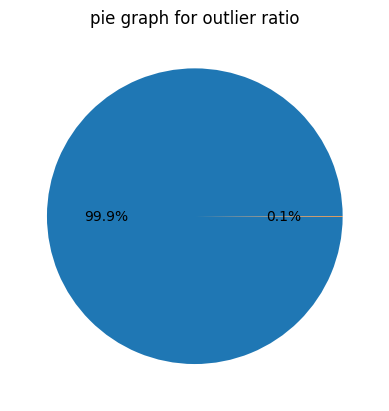

In [4]:
plt.pie(df_A[["anomaly"]].value_counts(),autopct='%1.1f%%')
plt.title("pie graph for outlier ratio")
plt.show()

In [5]:
df_true = df_A[df_A["anomaly"] == 1].iloc[:,1:(5+14+26+1)]
df_false = df_A[df_A["anomaly"] != 1].iloc[:,1:(5+14+26+1)]

## Q1~Q5 박스플랏
- 시계열 데이터를 박스플랏으로 보기는 조금 난해하지만 이상치가 표본으로부터 얼마나 거리가 떨어져있는지 확인하기 위해 박스플랏을 그려보았다
- Q3는 다른 데이터에 비해 분포가 매우 큰 차이가 날 것으로 보인다.

C:\Users\leonk\AppData\Local\Temp\ipykernel_29140\2584715716.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax[row, col].boxplot(
C:\Users\leonk\AppData\Local\Temp\ipykernel_29140\2584715716.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax[row, col].boxplot(
C:\Users\leonk\AppData\Local\Temp\ipykernel_29140\2584715716.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax[row, col].boxplot(
C:\Users\leonk\AppData\Local\Temp\ipykernel_29140\2584715716.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will 

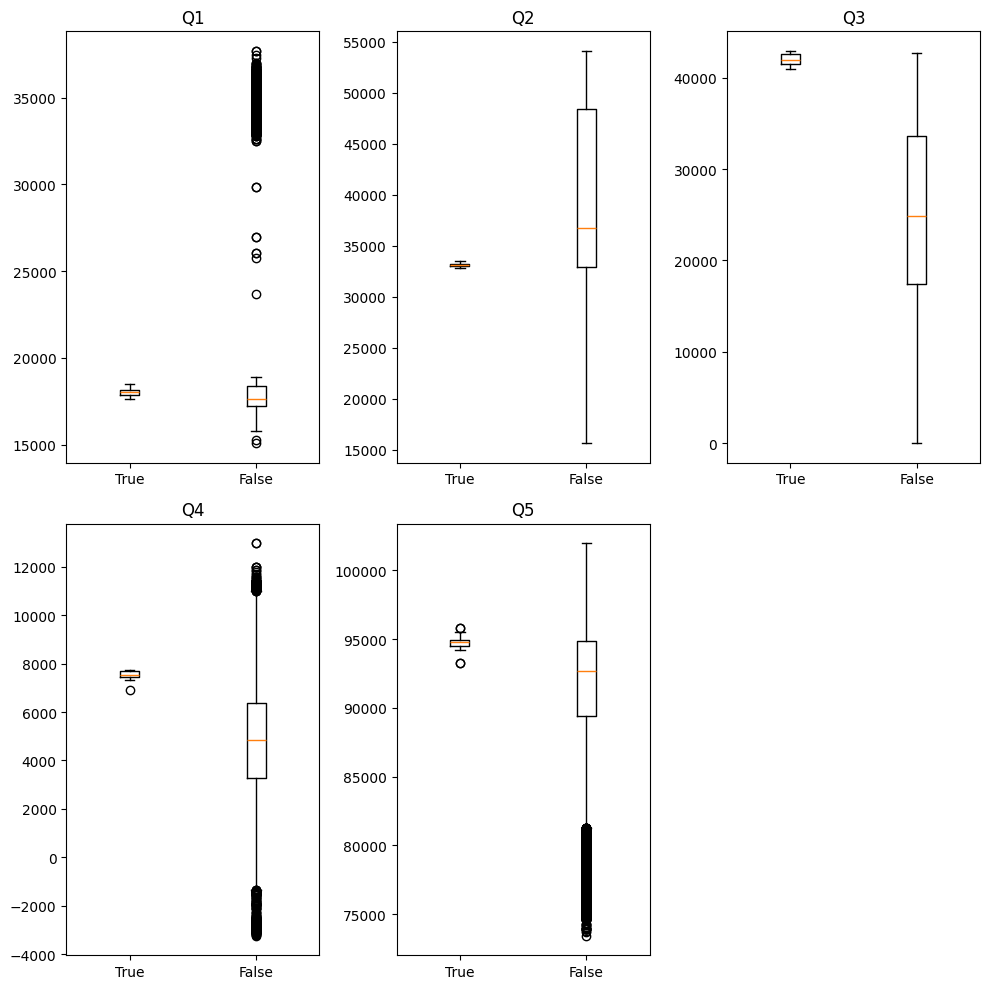

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 3, figsize=(10, 10))

titles = ["Q1", "Q2", "Q3", "Q4", "Q5"]
data = [df_true.iloc[:, i].values for i in range(5)]
labels = ["True", "False"]

for i in range(5):
    row, col = divmod(i, 3)  # 2x3 배열에서 행(row)과 열(col) 계산
    ax[row, col].boxplot(
        [data[i], df_false.iloc[:, i].values], 
        labels=labels
    )
    ax[row, col].set_title(titles[i])

# 필요 없는 격자 숨기기 (마지막 서브플롯)
ax[1, 2].axis("off")

plt.tight_layout()  # 레이아웃 조정
plt.show()

## Q1~Q5 시도표
- 그래프를 통해, 시계열 추세가 매우 변동이 큰 것을 보아 포인트를 찾는 이상치 기법보단 구간별로 이상치를 찾아야할 것으로 보인다.

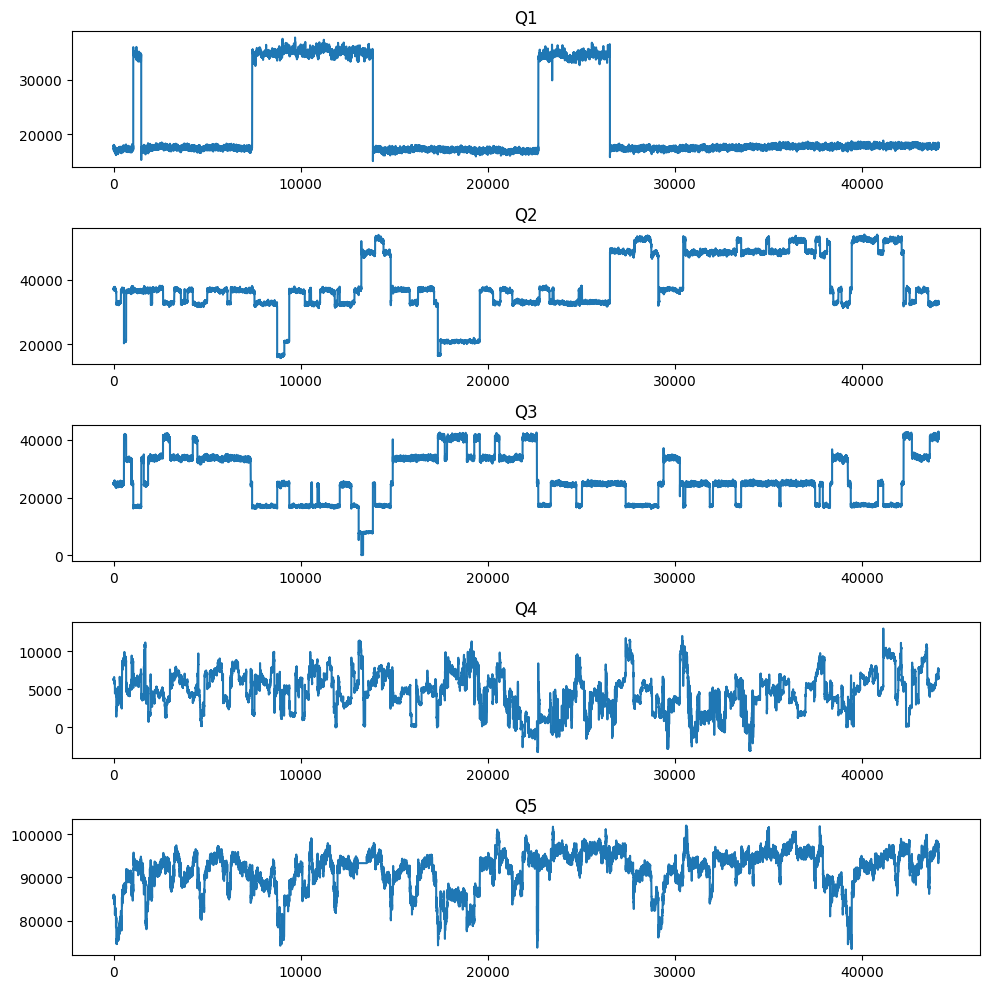

In [7]:
fig, ax = plt.subplots(5,1,figsize=(10,10))
for i in range(0,5):
    ax[i].plot(df_A[f'Q{i+1}'])
    ax[i].set_title(titles[i])

plt.tight_layout()
plt.show()

## 이상치 구간 시각화

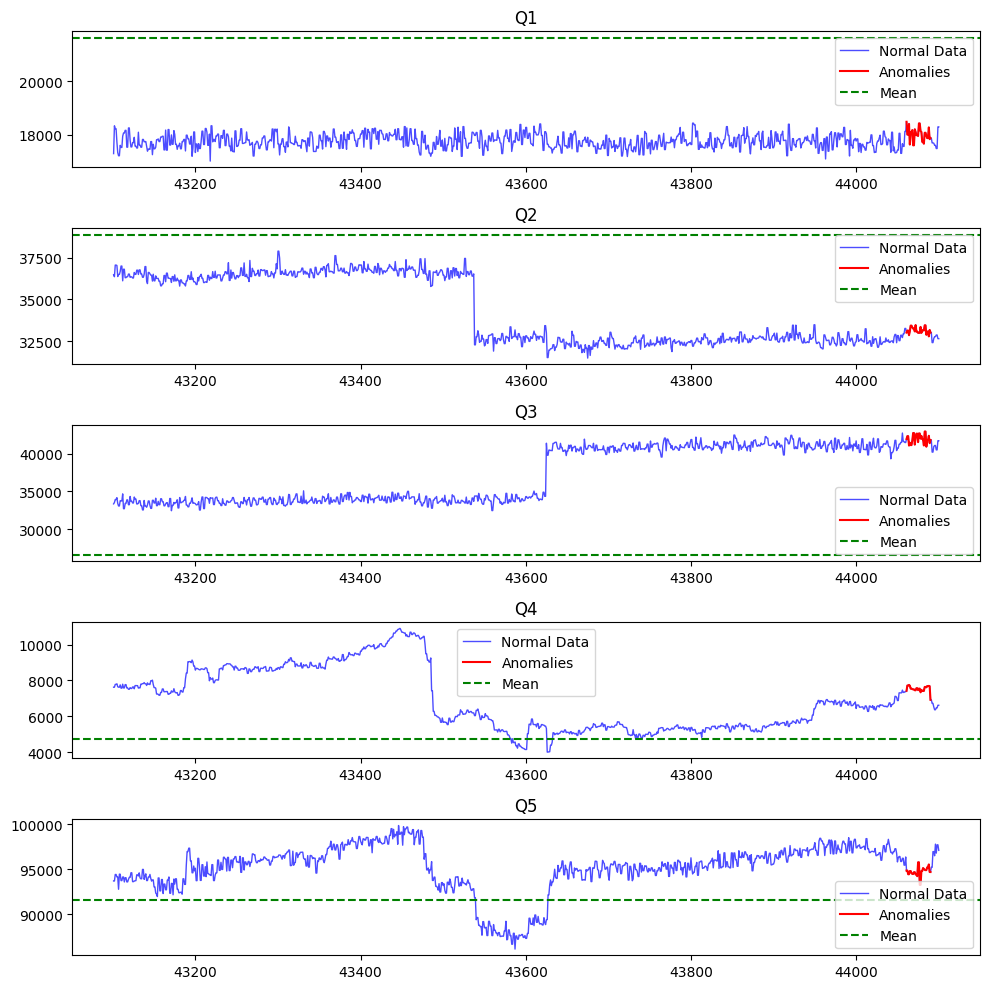

In [8]:
fig, ax = plt.subplots(5, 1, figsize=(10, 10))

# 제목 설정
titles = ["Q1", "Q2", "Q3", "Q4", "Q5"]

for i in range(5):
    # 정상 데이터 플롯
    ax[i].plot(
        df_A.index[-1000:],  # 시간 축
        df_A[f"Q{i+1}"][-1000:],  # Q 데이터
        label="Normal Data",
        color="blue",
        linewidth=1,
        alpha=0.7
    )

    # 이상치 데이터 플롯
    ax[i].plot(
        df_A.index[df_A["anomaly"] == 1],  # 이상치의 시간
        df_A[f"Q{i+1}"][df_A["anomaly"] == 1],  # 이상치의 값
        label="Anomalies",
        color="red",
        linewidth=1.5  # 두께 강조
    )

    # 제목과 범례 추가
    ax[i].set_title(titles[i])
    ax[i].legend()
    mean_value = df_A[f"Q{i+1}"].mean()  # 평균값 계산
    ax[i].axhline(mean_value, color="green", linestyle="--", label="Mean")  # 수평선 추가

    # 제목 및 범례 추가
    ax[i].set_title(f'Q{i+1}')
    ax[i].legend()
plt.tight_layout()  # 레이아웃 조정
plt.show()


## M1~M14
- 아래 표는 이상치 여부가 1인 데이터의 M1~M14를 합산하여 평균낸 것으로 이상치가 탐지된 구간에서 비율이 1인 것을 알 수 있다.
  - 이는 TRAIN_A 데이터에서 이상치는 M4, M8, M9, M11, M12, M14이 무조건 1로 체크되어있다는 의미이다.
- 하지만 이상치여부가 0인 데이터는 이상치와는 다르게 집계된 것을 확인할 수 있다.

In [9]:
pd.DataFrame({'anomaly':np.sum(df_true.iloc[:,5:(5+14)],axis=0) / 30,
              'No anomaly':np.sum(df_false.iloc[:,5:(5+14)],axis=0) / len(df_false)})#,np.sum(df_false.iloc[:,5:(5+14)],axis=0)

,anomaly,No anomaly
M1,0.0,0.000000
M2,0.0,0.000000
M3,0.0,0.000000
M4,1.0,0.999977
M5,0.0,0.243153
M6,0.0,0.619863
M7,0.0,0.496245
M8,1.0,0.769758
M9,1.0,0.877584
M10,0.0,0.000000


## P1 ~ P26 시도표
- 관망구조를 보면 P1부터 P26은 하나의 구조로 이루어져 있는 것을 확인하였다.
- 이는 서로 집계되는 압력이 어느정도 상관관계가 있을 것으로 보이며, 다변량 문제로 접근해봐야 한다는 의미로도 볼 수 있다.
- 시도표에서도 추세, 계절 성분으로 보이는 것들이 근접한 P 사이에서 대체적으로 비슷하게 나타나 있는 것을 확인할 수 있었다. 

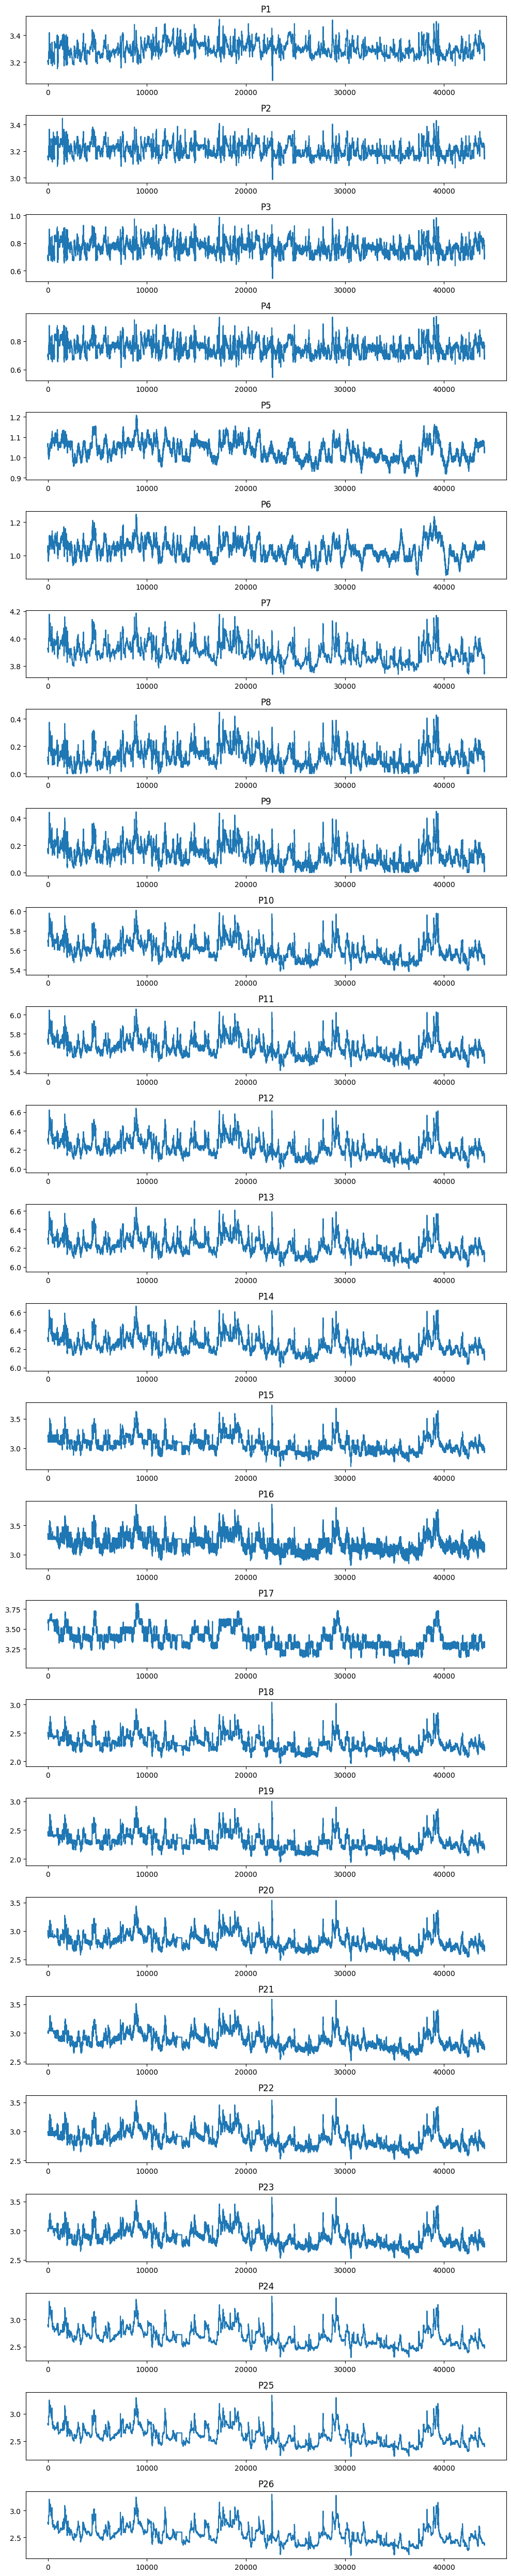

In [10]:
P = df_true.columns[[df_true.columns[i][0] == 'P' for i in range(len(df_true.columns))]]

fig, ax = plt.subplots(len(P),1,figsize=(10,50))
df_Ap= df_A[P]
for i in range(len(P)):
    ax[i].plot(df_Ap[f'P{i+1}'])
    ax[i].set_title(P[i])

plt.tight_layout()
plt.show()

## 이상치 시각화

- P 데이터는 이상치 여부를 판단하는 아주 중요한 변수로 보인다.
- TEST SET에서도 P의 개수에 따라 제출해야하는 이상치 개수가 달라진다. 예를 들어 TEST-C0000이 P가 10개면, 10개에 대한 이상치 탐지 여부를 제출해야한다는 의미이다.

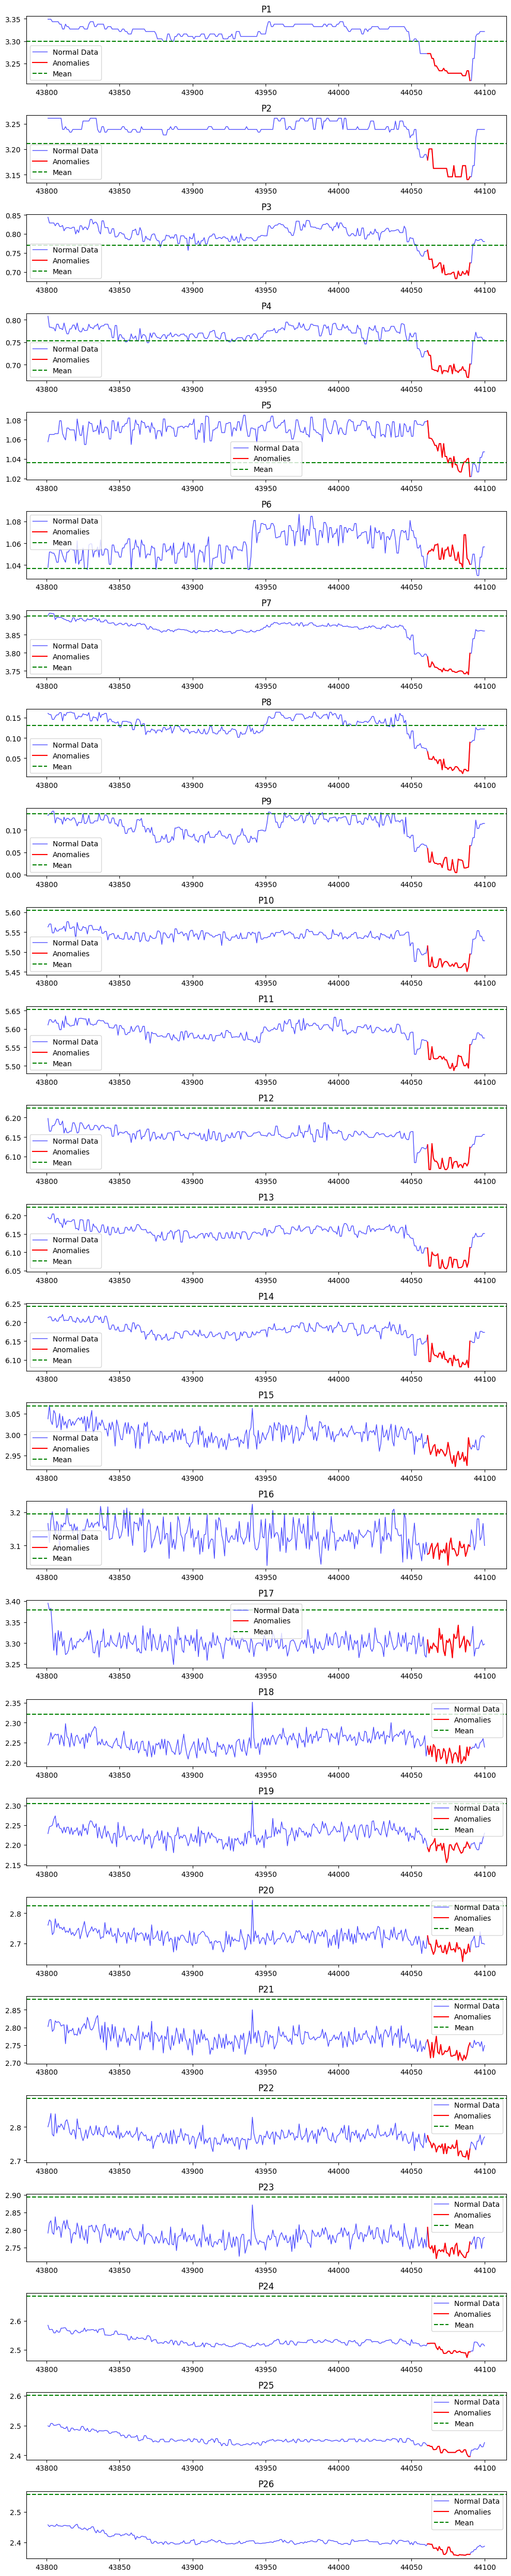

In [11]:
# P로 시작하는 컬럼 선택
P = df_true.columns[[df_true.columns[i][0] == 'P' for i in range(len(df_true.columns))]]
df_Ap = df_A[P]  # P로 시작하는 열만 선택

# 플롯 생성
fig, ax = plt.subplots(len(P), 1, figsize=(10, 50))

for i in range(len(P)):
    # 정상 데이터 플롯
    ax[i].plot(
        df_A.index[-300:],  # 시간 축
        df_Ap[P[i]][-300:],  # P 데이터
        label="Normal Data",
        color="blue",
        linewidth=1,
        alpha=0.7
    )

    # 이상치 데이터 플롯
    ax[i].plot(
        df_A.index[df_A["anomaly"] == 1],  # 이상치 시간
        df_Ap[P[i]][df_A["anomaly"] == 1],  # 이상치 값
        label="Anomalies",
        color="red",
        linewidth=1.5  # 두께 강조
    )

    # 평균선 추가
    mean_value = df_Ap[P[i]].mean()  # 평균값 계산
    ax[i].axhline(mean_value, color="green", linestyle="--", label="Mean")  # 수평선 추가

    # 제목 및 범례 추가
    ax[i].set_title(P[i])
    ax[i].legend()

plt.tight_layout()  # 레이아웃 조정
plt.show()


In [12]:
import pandas as pd

# anomaly == 1인 데이터에서 timestamp 열만 선택
timestamps = df_A[df_A["anomaly"] == 1]["timestamp"]

# DataFrame으로 변환 (엑셀 저장을 위해)
timestamps_df = timestamps.reset_index(drop=True).to_frame(name="timestamp")

# 엑셀 파일로 저장
timestamps_df.to_excel("timestamps.xlsx", index=False)

print("timestamp 데이터가 'timestamps.xlsx' 파일로 저장되었습니다.")

timestamp 데이터가 'timestamps.xlsx' 파일로 저장되었습니다.


In [13]:
timestamps_df

,timestamp
0,24/06/26 14:21
1,24/06/26 14:22
2,24/06/26 14:23
3,24/06/26 14:24
4,24/06/26 14:25
5,24/06/26 14:26
6,24/06/26 14:27
7,24/06/26 14:28
8,24/06/26 14:29
9,24/06/26 14:30


In [14]:
df_A[df_A["anomaly"] == 1]

,timestamp,Q1,Q2,Q3,Q4,Q5,M1,M2,M3,M4,...,P17_flag,P18_flag,P19_flag,P20_flag,P21_flag,P22_flag,P23_flag,P24_flag,P25_flag,P26_flag
44061,24/06/26 14:21,18490,33011.001,41933.003,7424,94856,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
44062,24/06/26 14:22,18010,33131.001,42305.000,7720,94856,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
44063,24/06/26 14:23,18010,33131.001,42305.000,7720,94447,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
44064,24/06/26 14:24,18410,32854.001,41058.003,7752,94447,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
44065,24/06/26 14:25,17640,33086.001,41443.003,7711,94802,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
44066,24/06/26 14:26,18100,33428.000,41121.001,7544,94802,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
44067,24/06/26 14:27,18100,33428.000,41121.001,7544,94577,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
44068,24/06/26 14:28,18180,33322.000,41728.999,7517,94484,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
44069,24/06/26 14:29,17610,33248.000,42721.001,7504,94473,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
44070,24/06/26 14:30,17610,33248.000,42721.001,7504,94672,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [15]:
#시계열 자료로 변환
df_A['timestamp'] = pd.to_datetime(df_A['timestamp'], format='%y/%m/%d %H:%M')

In [16]:
df_A['timestamp'].head()

0   2024-05-27 00:00:00
1   2024-05-27 00:01:00
2   2024-05-27 00:02:00
3   2024-05-27 00:03:00
4   2024-05-27 00:04:00
Name: timestamp, dtype: datetime64[ns]

In [17]:
# anomaly가 1인 시간대 찾기
anomaly_times = df_A[df_A['anomaly'] == 1]['timestamp']

In [18]:
print(df_A['timestamp'].min(), df_A['timestamp'].max())

2024-05-27 00:00:00 2024-06-26 15:00:00


In [19]:
# anomaly가 1인 연속된 구간 찾기
anomaly_start = df_A[df_A['anomaly'] == 1]['timestamp'].min()
anomaly_end = df_A[df_A['anomaly'] == 1]['timestamp'].max()

In [20]:
anomaly_start

Timestamp('2024-06-26 14:21:00')

In [21]:
anomaly_end

Timestamp('2024-06-26 14:50:00')

In [22]:
# 전후 60분 시간 범위 설정
start_time = anomaly_start - pd.Timedelta(minutes=60)
end_time = anomaly_end + pd.Timedelta(minutes=60)

In [23]:
start_time

Timestamp('2024-06-26 13:21:00')

In [24]:
end_time

Timestamp('2024-06-26 15:50:00')

In [25]:
# 데이터 추출
filtered_data = df_A[(df_A['timestamp'] >= start_time) & (df_A['timestamp'] <= end_time)]

In [26]:
filtered_data

,timestamp,Q1,Q2,Q3,Q4,Q5,M1,M2,M3,M4,...,P17_flag,P18_flag,P19_flag,P20_flag,P21_flag,P22_flag,P23_flag,P24_flag,P25_flag,P26_flag
44001,2024-06-26 13:21:00,17850,32880.000,40663.000,6628,97371,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
44002,2024-06-26 13:22:00,17850,32880.000,40663.000,6628,97591,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
44003,2024-06-26 13:23:00,17370,32479.001,41183.003,6624,97591,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
44004,2024-06-26 13:24:00,17680,32557.000,40148.000,6507,97710,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
44005,2024-06-26 13:25:00,17680,32557.000,40148.000,6507,97326,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44096,2024-06-26 14:56:00,17610,32767.000,41071.001,6364,97783,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
44097,2024-06-26 14:57:00,17490,32866.001,40488.000,6469,96785,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
44098,2024-06-26 14:58:00,17490,32866.001,40488.000,6469,97707,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
44099,2024-06-26 14:59:00,18300,32646.001,41702.002,6616,97707,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [27]:
filtered_data.head()

,timestamp,Q1,Q2,Q3,Q4,Q5,M1,M2,M3,M4,...,P17_flag,P18_flag,P19_flag,P20_flag,P21_flag,P22_flag,P23_flag,P24_flag,P25_flag,P26_flag
44001,2024-06-26 13:21:00,17850,32880.000,40663.000,6628,97371,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
44002,2024-06-26 13:22:00,17850,32880.000,40663.000,6628,97591,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
44003,2024-06-26 13:23:00,17370,32479.001,41183.003,6624,97591,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
44004,2024-06-26 13:24:00,17680,32557.000,40148.000,6507,97710,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
44005,2024-06-26 13:25:00,17680,32557.000,40148.000,6507,97326,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


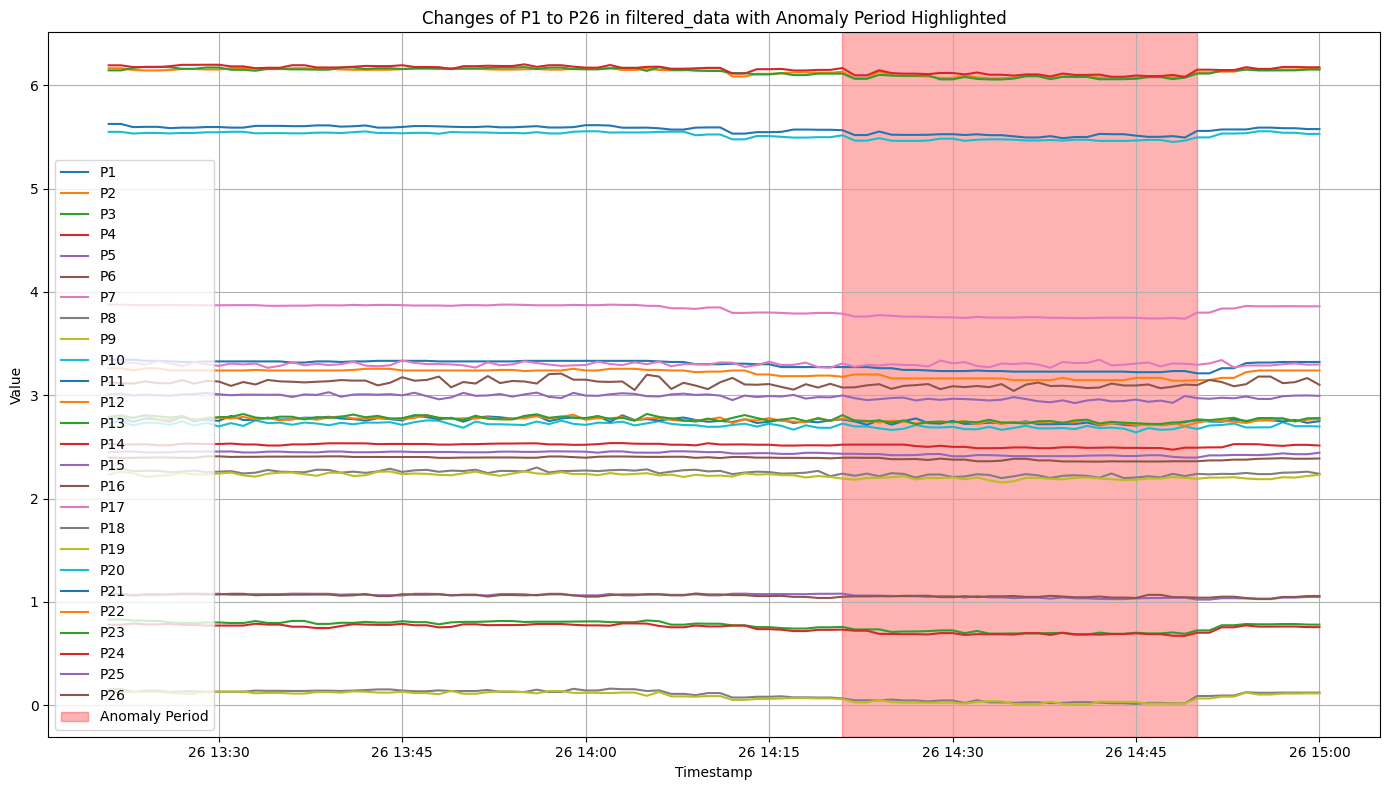

In [28]:
# p1부터 p10까지의 데이터 시각화
plt.figure(figsize=(14, 8))
for i in range(1, 27):
    plt.plot(filtered_data['timestamp'], filtered_data[f'P{i}'], label=f'P{i}')

# anomaly 구간 강조
plt.axvspan(anomaly_start, anomaly_end, color='red', alpha=0.3, label='Anomaly Period')

plt.title('Changes of P1 to P26 in filtered_data with Anomaly Period Highlighted')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


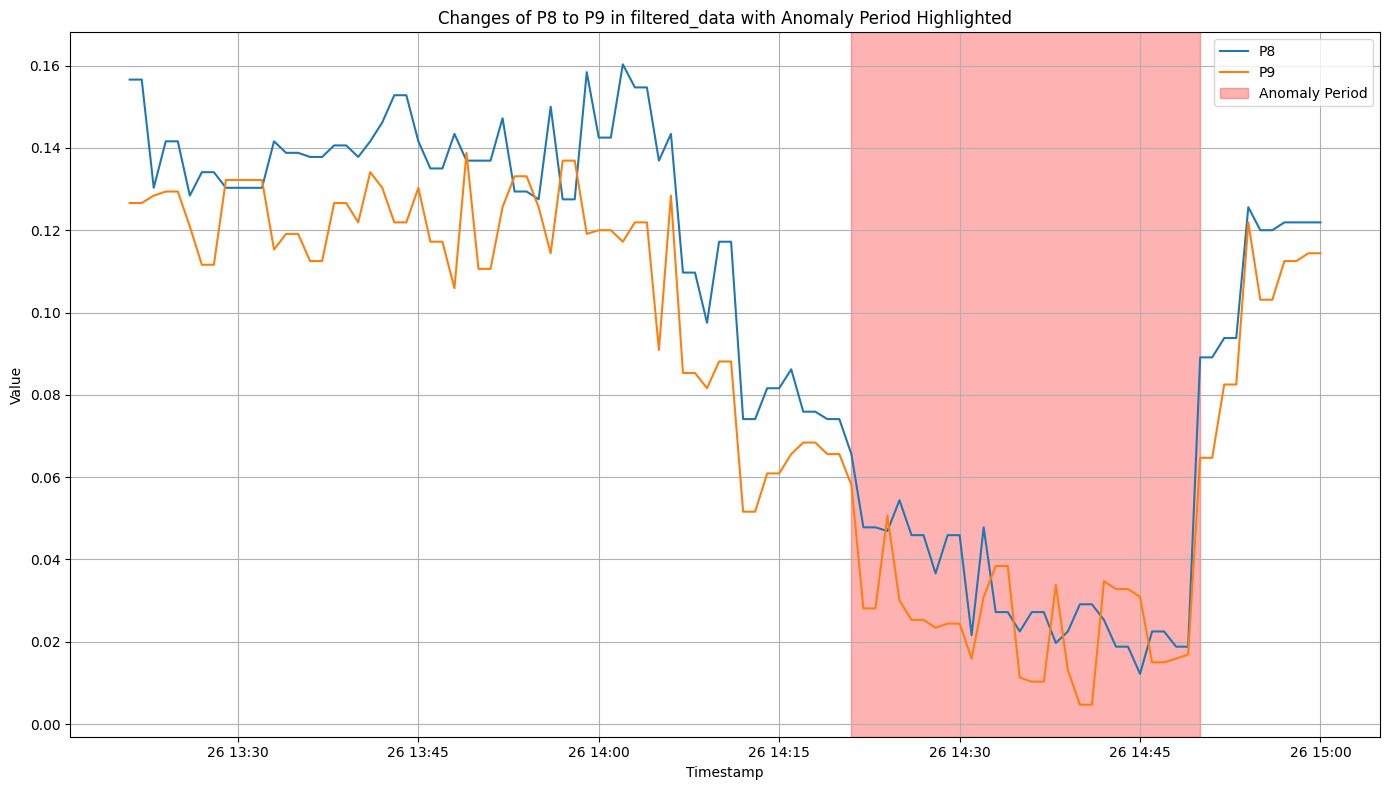

In [29]:
# p1부터 p10까지의 데이터 시각화
plt.figure(figsize=(14, 8))
for i in range(8, 10):
    plt.plot(filtered_data['timestamp'], filtered_data[f'P{i}'], label=f'P{i}')

# anomaly 구간 강조
plt.axvspan(anomaly_start, anomaly_end, color='red', alpha=0.3, label='Anomaly Period')

plt.title('Changes of P8 to P9 in filtered_data with Anomaly Period Highlighted')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [30]:
# 숫자형 컬럼만 선택 (timestamp와 같은 비숫자형 컬럼 제외)
numeric_columns = filtered_data.select_dtypes(include=[np.number]).columns

In [31]:
# P8, P9를 포함한 모든 숫자형 컬럼 간의 상관관계 계산
correlation_matrix = filtered_data[numeric_columns].corr()

In [32]:
# P8, P9와 다른 컬럼들 간의 상관관계만 선택
p8_p9_correlations = correlation_matrix.loc[['P8', 'P9'], :]

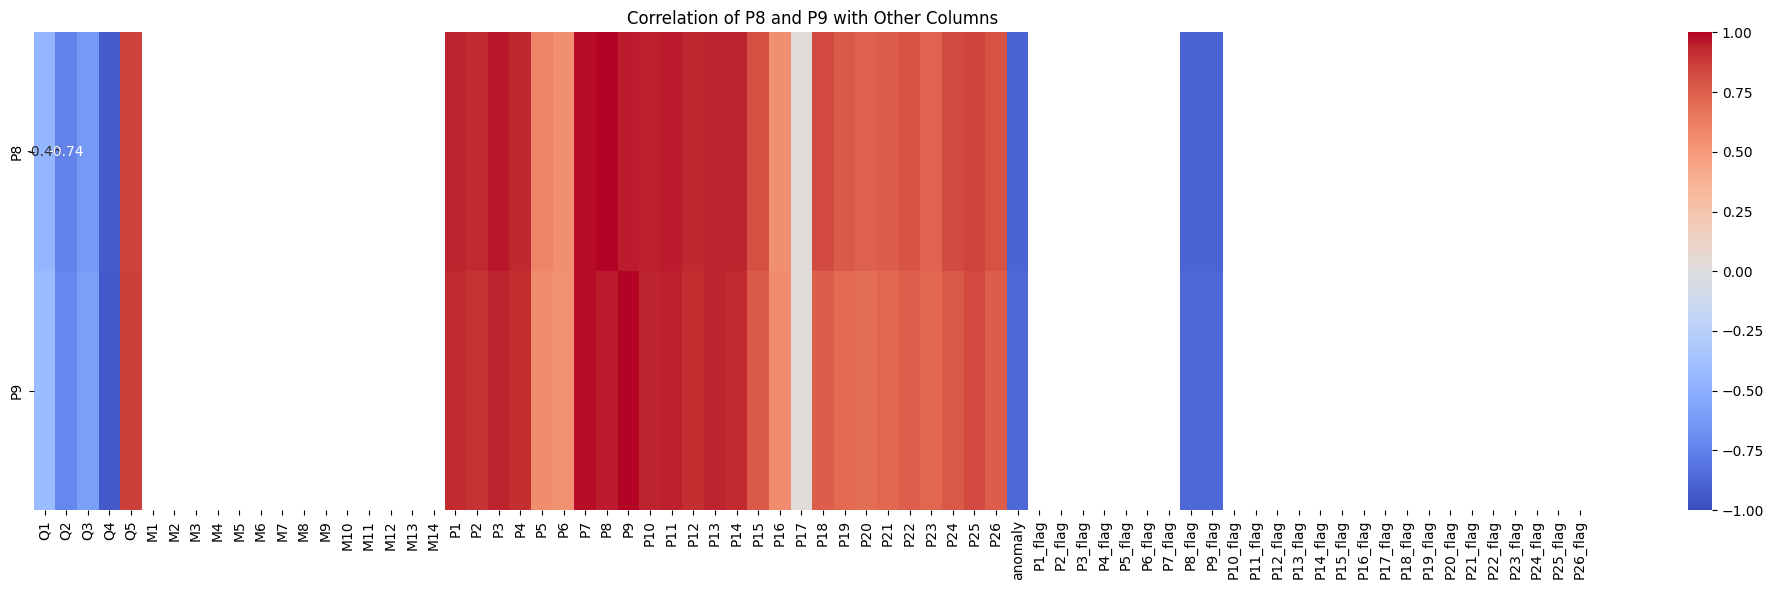

In [33]:
# 히트맵 생성
plt.figure(figsize=(20, 6))
sns.heatmap(p8_p9_correlations, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation of P8 and P9 with Other Columns')
plt.tight_layout()
plt.show()

In [34]:
# P8, P9와 가장 상관관계가 높은 상위 5개 컬럼 출력
print("P8과 가장 상관관계가 높은 상위 10개 컬럼:")
print(correlation_matrix['P8'].sort_values(ascending=False)[1:11])  # P8 자신 제외

P8과 가장 상관관계가 높은 상위 10개 컬럼:
P7     0.983496
P3     0.962364
P9     0.959688
P11    0.954195
P10    0.949401
P13    0.944422
P1     0.938422
P14    0.937958
P4     0.933875
P12    0.931073
Name: P8, dtype: float64


In [35]:
# P8, P9와 가장 상관관계가 높은 상위 5개 컬럼 출력
print("P9와 가장 상관관계가 높은 상위 10개 컬럼:")
print(correlation_matrix['P9'].sort_values(ascending=False)[1:11])

P9와 가장 상관관계가 높은 상위 10개 컬럼:
P7     0.977833
P8     0.959688
P11    0.948598
P3     0.945065
P10    0.942088
P13    0.940732
P14    0.929477
P1     0.925561
P12    0.914743
P4     0.914724
Name: P9, dtype: float64


C:\Users\leonk\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


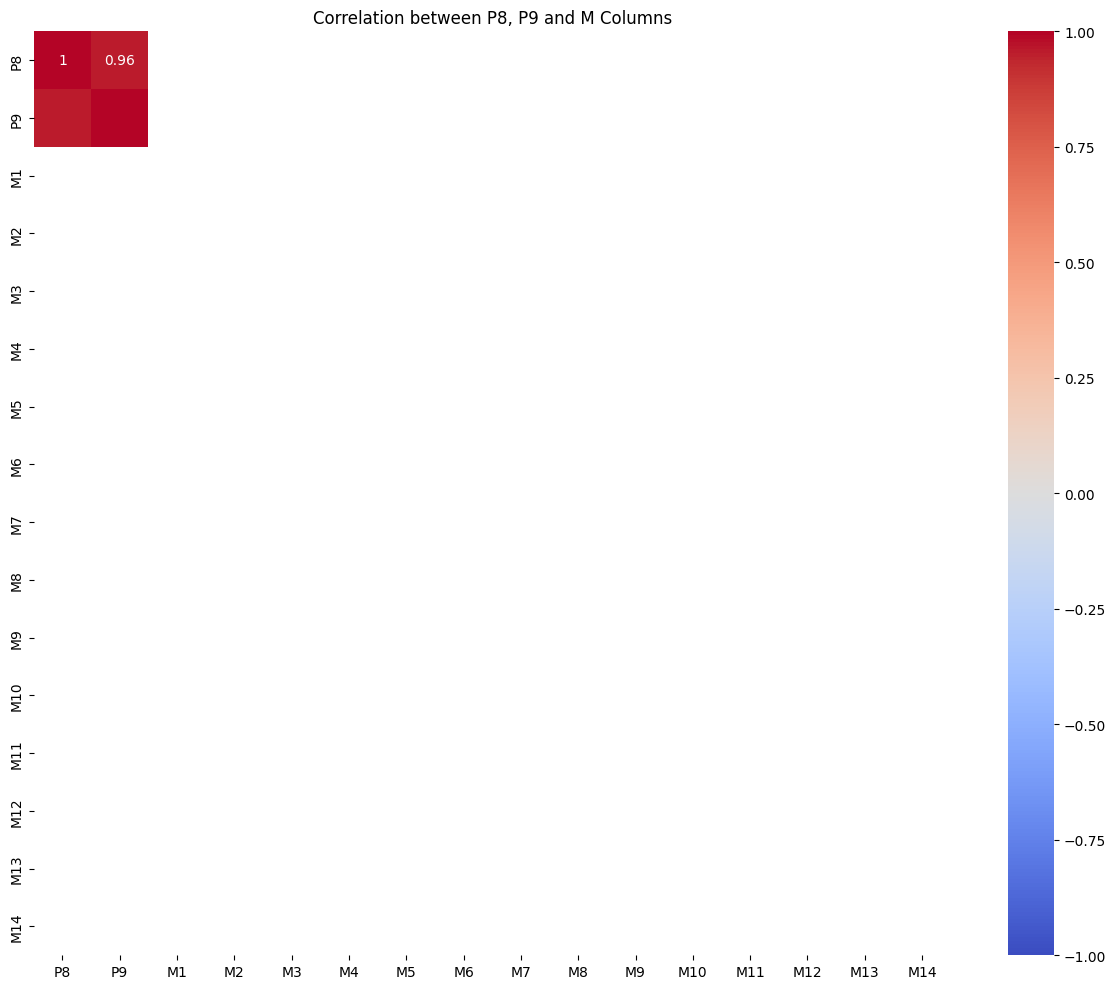

In [36]:
# M으로 시작하는 컬럼 선택
m_columns = [col for col in filtered_data.columns if col.startswith('M')]

# P8, P9와 M으로 시작하는 컬럼 간의 상관관계 계산
correlation_matrix_p_m = filtered_data[['P8', 'P9'] + m_columns].corr()

# 히트맵 생성
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_p_m, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation between P8, P9 and M Columns')
plt.tight_layout()
plt.show()


- Anomaly를 관측할 때 펌프와 압력사이의 상관관계가 0일수록 누수가 났을 가능성이 높다(가설)
- TrainB도 이 가설처럼 나오면 모델을 돌릴때 펌프의 역할은 거의 없을 수도 있다

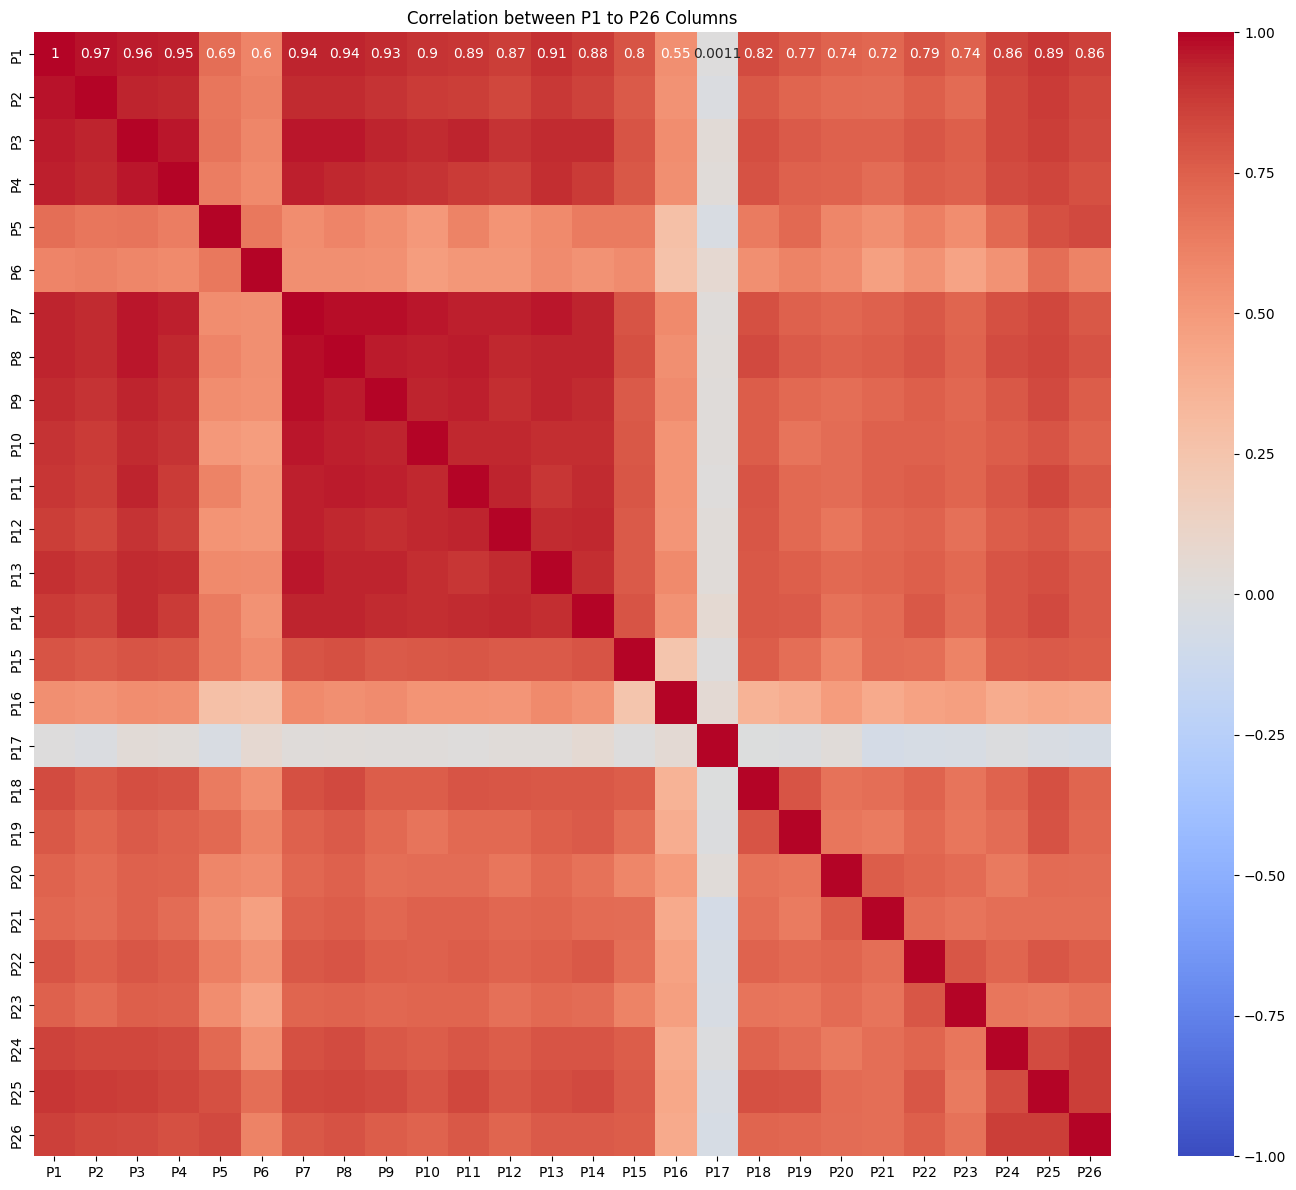

In [37]:
# P1부터 P26까지의 컬럼 선택
p_columns = [f'P{i}' for i in range(1, 27)]

# P1부터 P26까지의 상관관계 계산
correlation_matrix_p = filtered_data[p_columns].corr()

# 히트맵 생성
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix_p, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation between P1 to P26 Columns')
plt.tight_layout()
plt.show()
#p17은 고인물

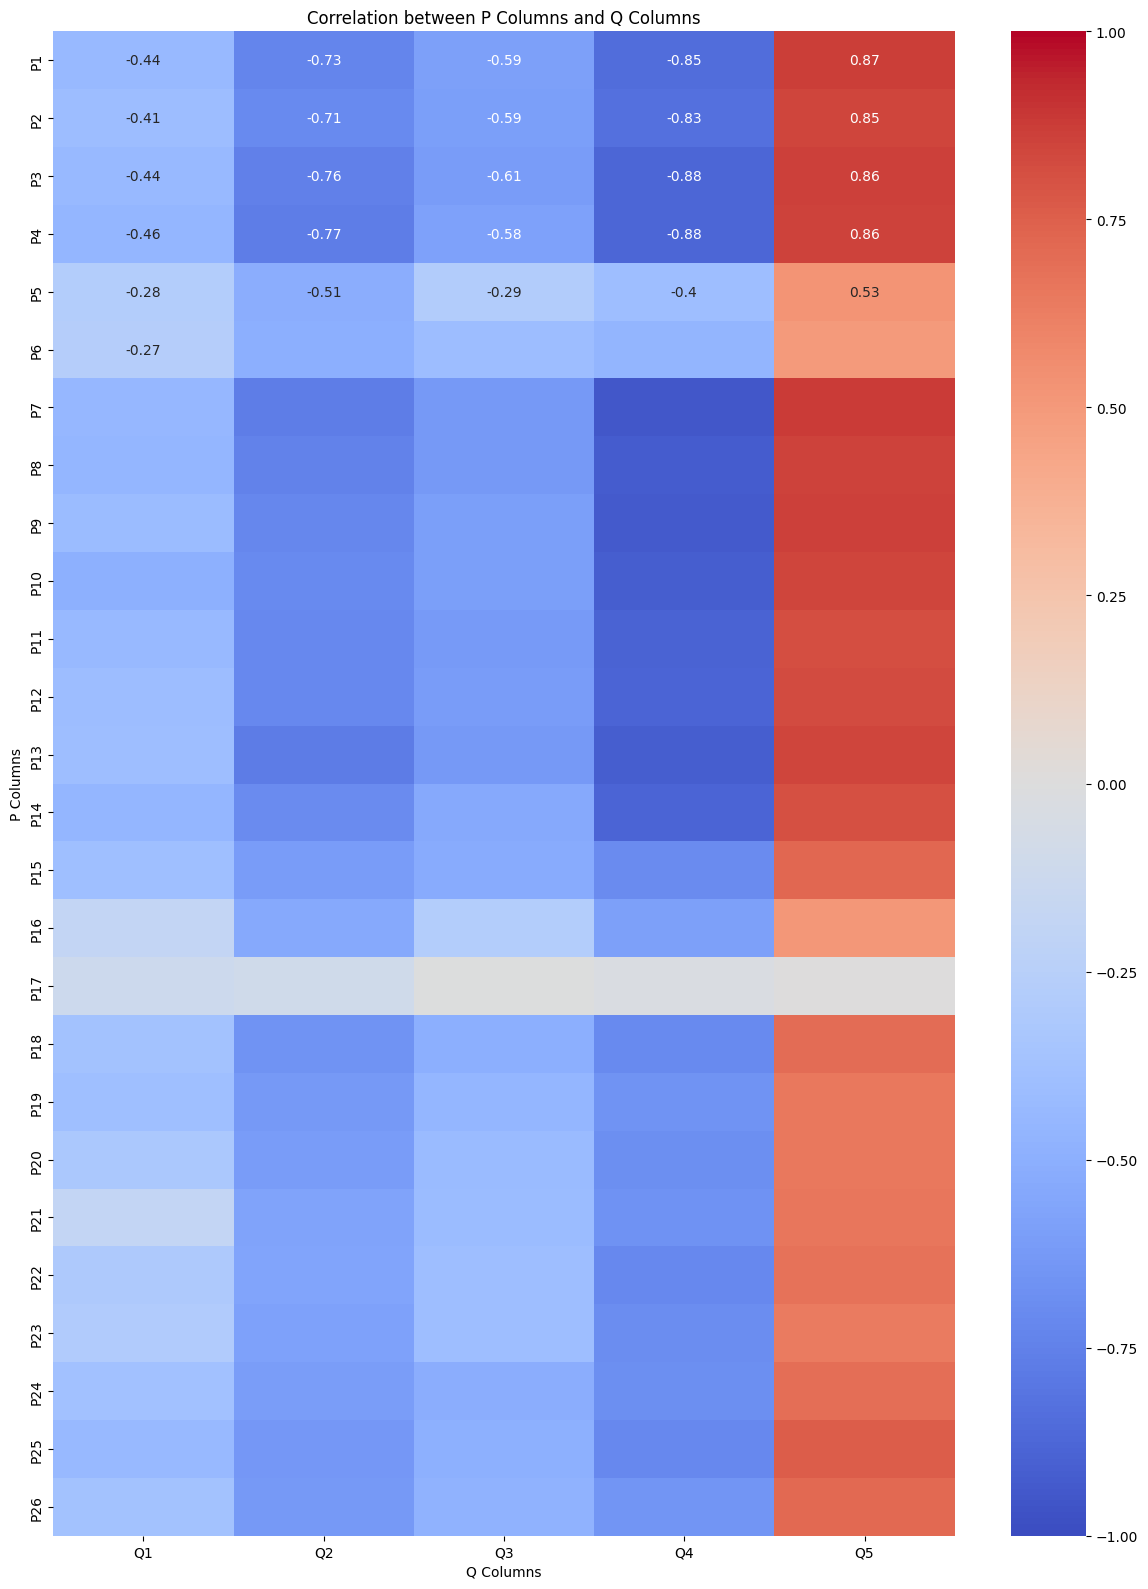

가장 높은 상관관계를 가진 P-Q 쌍 5개:
P7 - Q4: -0.9529
P9 - Q4: -0.9355
P8 - Q4: -0.9292
P10 - Q4: -0.9159
P13 - Q4: -0.9144


In [38]:
# P1부터 P26까지의 컬럼과 Q1부터 Q5까지의 컬럼 선택
p_columns = [f'P{i}' for i in range(1, 27)]
q_columns = [f'Q{i}' for i in range(1, 6)]

# P 컬럼들과 Q 컬럼들 간의 상관관계 계산
correlation_matrix_pq = filtered_data[p_columns + q_columns].corr().loc[p_columns, q_columns]

# 히트맵 생성
plt.figure(figsize=(12, 16))
sns.heatmap(correlation_matrix_pq, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation between P Columns and Q Columns')
plt.xlabel('Q Columns')
plt.ylabel('P Columns')
plt.tight_layout()
plt.show()

# 가장 높은 상관관계를 가진 P-Q 쌍 5개 출력
correlation_pairs = []
for p in p_columns:
    for q in q_columns:
        correlation_pairs.append((p, q, correlation_matrix_pq.loc[p, q]))

top_5_correlations = sorted(correlation_pairs, key=lambda x: abs(x[2]), reverse=True)[:5]

print("가장 높은 상관관계를 가진 P-Q 쌍 5개:")
for p, q, corr in top_5_correlations:
    print(f"{p} - {q}: {corr:.4f}")

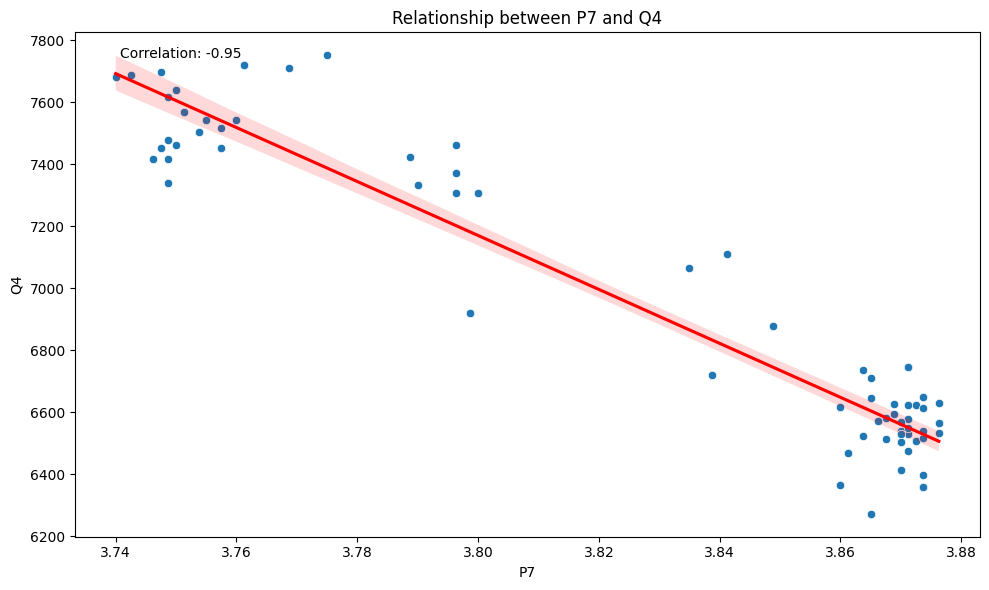

P7와 Q4의 상관계수: -0.9529

기술 통계:
               P7           Q4
count  100.000000   100.000000
mean     3.826018  6943.850000
std      0.051850   473.741211
min      3.740000  6272.000000
25%      3.761300  6538.750000
50%      3.860000  6715.500000
75%      3.871200  7431.000000
max      3.876300  7752.000000


In [39]:
# 산점도 생성
plt.figure(figsize=(10, 6))
sns.scatterplot(data=filtered_data, x='P7', y='Q4')

# 회귀선 추가
sns.regplot(data=filtered_data, x='P7', y='Q4', scatter=False, color='red')

# 그래프 제목과 축 레이블 설정
plt.title('Relationship between P7 and Q4')
plt.xlabel('P7')
plt.ylabel('Q4')

# 상관계수 계산 및 표시
correlation = filtered_data['P7'].corr(filtered_data['Q4'])
plt.text(0.05, 0.95, f'Correlation: {correlation:.2f}', transform=plt.gca().transAxes)

plt.tight_layout()
plt.show()

# 추가적인 통계 정보 출력
print(f"P7와 Q4의 상관계수: {correlation:.4f}")
print("\n기술 통계:")
print(filtered_data[['P7', 'Q4']].describe())

## 전체 데이터의 경우

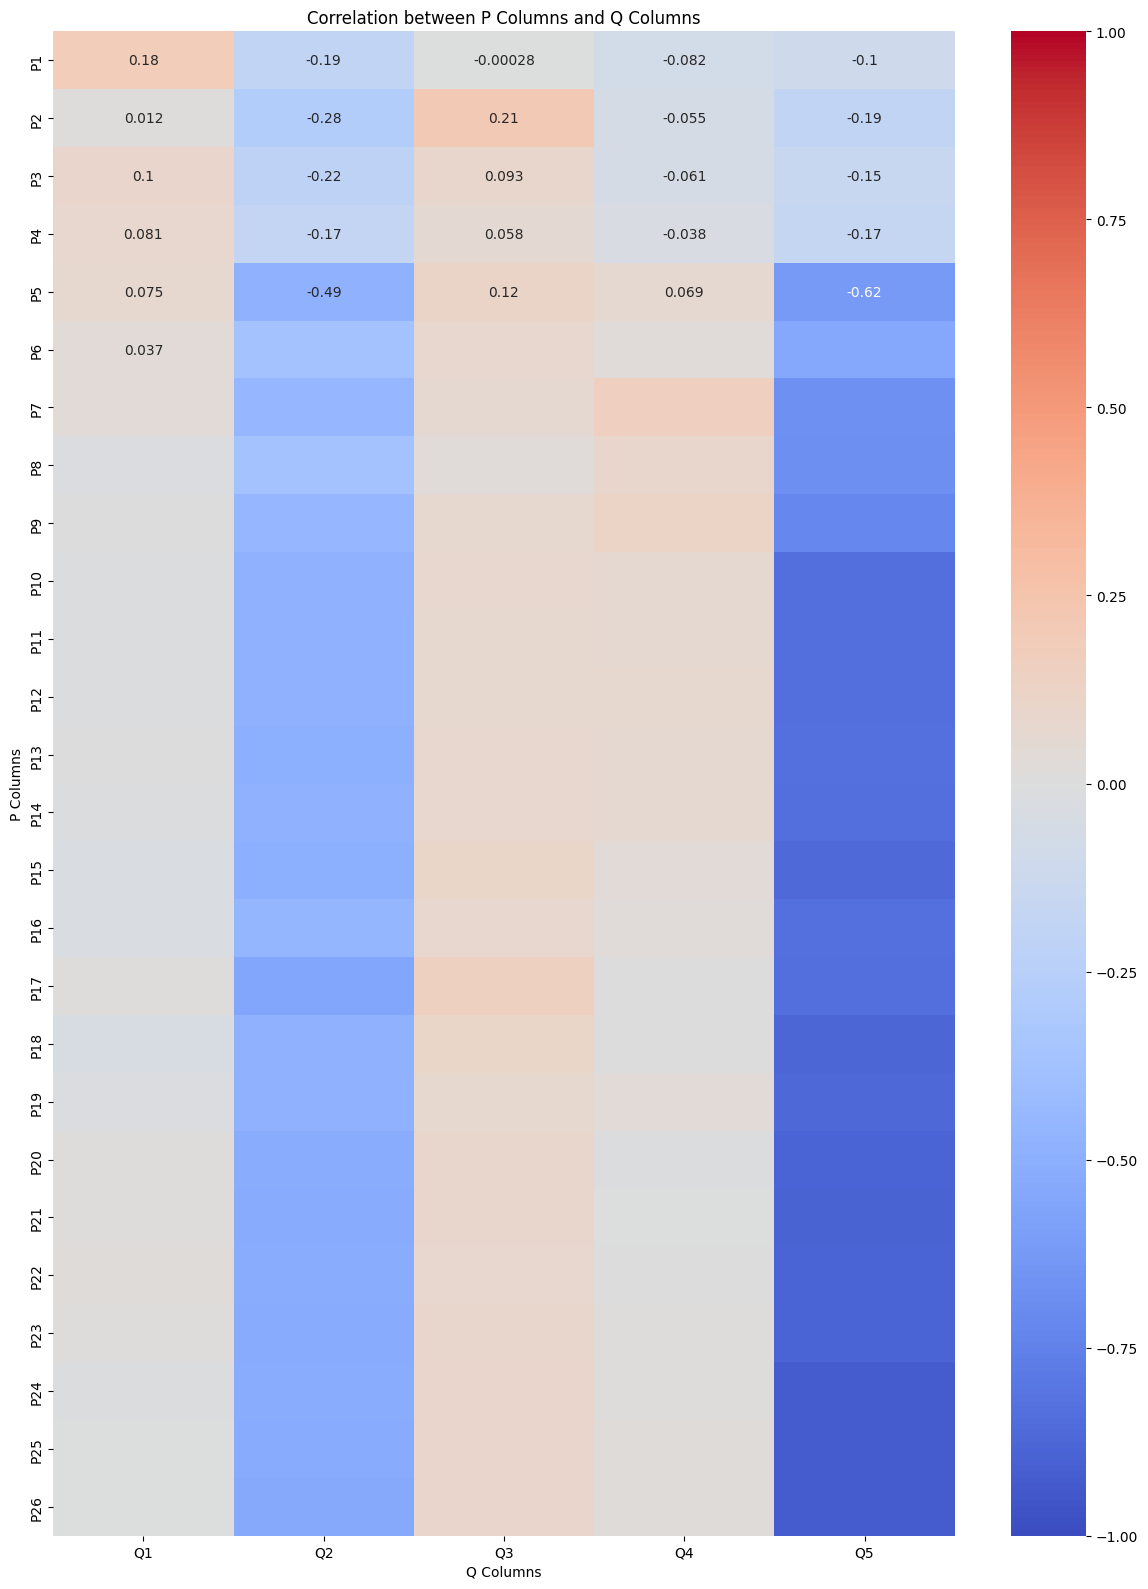

가장 높은 상관관계를 가진 P-Q 쌍 5개:
P24 - Q5: -0.9269
P26 - Q5: -0.9243
P25 - Q5: -0.9240
P21 - Q5: -0.8932
P23 - Q5: -0.8905


In [40]:
# P1부터 P26까지의 컬럼과 Q1부터 Q5까지의 컬럼 선택
p_columns = [f'P{i}' for i in range(1, 27)]
q_columns = [f'Q{i}' for i in range(1, 6)]

# P 컬럼들과 Q 컬럼들 간의 상관관계 계산
correlation_matrix_pq = df_A[p_columns + q_columns].corr().loc[p_columns, q_columns]

# 히트맵 생성
plt.figure(figsize=(12, 16))
sns.heatmap(correlation_matrix_pq, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation between P Columns and Q Columns')
plt.xlabel('Q Columns')
plt.ylabel('P Columns')
plt.tight_layout()
plt.show()

# 가장 높은 상관관계를 가진 P-Q 쌍 5개 출력
correlation_pairs = []
for p in p_columns:
    for q in q_columns:
        correlation_pairs.append((p, q, correlation_matrix_pq.loc[p, q]))

top_5_correlations = sorted(correlation_pairs, key=lambda x: abs(x[2]), reverse=True)[:5]

print("가장 높은 상관관계를 가진 P-Q 쌍 5개:")
for p, q, corr in top_5_correlations:
    print(f"{p} - {q}: {corr:.4f}")